# Visual NLP ChartToTextTable

In [1]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_8803 (1).json to spark_nlp_for_healthcare_spark_ocr_8803 (1).json


In [2]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 1.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/5.2.0-8fe2fa510a6f424b2232f2066e44b31fb48753d9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 983.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from pyspark.sql.functions import explode

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

from sparkocr.transformers import ChartToTextTable

In [3]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 5.2.2
Spark OCR version: 5.2.0



### Define pipeline

In [4]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

chart_to_text = ChartToTextTable()\
    .pretrained("chart_to_text_deplot_jsl", "en", "clinical/ocr")\
    .setInputCol(["image"])\
    .setOutputCol("answers")\
    .setUseCaching(False)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    chart_to_text
])

chart_to_text_deplot_jsl download started this may take some time.
Approximate size to download 999.7 MB


### Load test images

In [9]:
test_image_path = './data/charts/chart1.png'

In [10]:
# import pkg_resources
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/dat...|2024-04-04 16:47:...| 16697|[89 50 4E 47 0D 0...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/content/data/charts/chart1.png
    Resolution: 0 dpi
    Width: 1000 px
    Height: 685 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


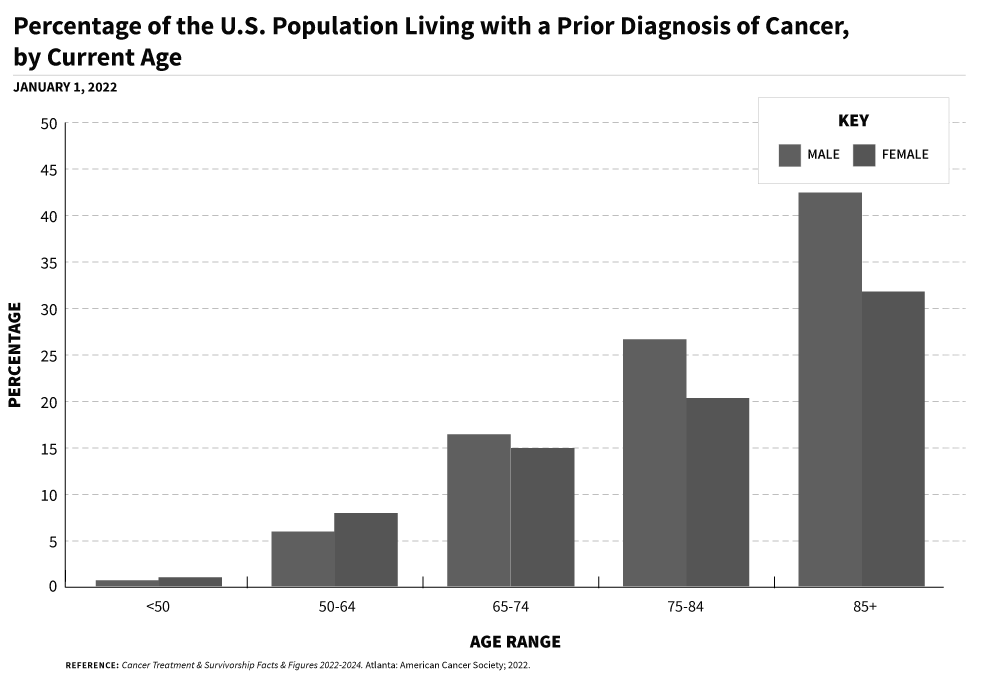

In [11]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

## Call pipeline

In [12]:
results = pipeline.transform(bin_df).cache()

In [13]:
results.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- answers: struct (nullable = true)
 |    |-- questions: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- answers: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- scores: array (nullable = true)
 |    |    |-- element: float (containsNull = false)



In [15]:
result = results.select(results.answers.answers).first()[0]

## Results from Deplot

In [18]:
result[0]

'  TITLE | Percentage of the U.S. Population Living with a Prior Diagnosis of Cancer, by Current Age<0x0A>AGE RANGE | MALE | FEMALE<0x0A>20-50 | 0.80 | 1.10<0x0A>50-64 | 6.10 | 8.10<0x0A>65-74 | 16.40 | 15.10<0x0A>75-84 | 26.60 | 20.30<0x0A>85+ | 42.60 | 31.90'

## LLM part: explaining the Deplot chart results using LLAMA2-7B

In [19]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 5.4 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 10.2 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 20.0 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 32.0 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.9 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.7 MB/s eta 0:00:00
    Creating /tmp/pip-build-env-16xvvoek/overlay/local/bin
    changing mode of /tmp/pip-build-env-16xvvoek/overlay/local/bin/ninja to 755
    changing mode of /tmp/pip-build-env-16xvvoek/overlay/lo

In [21]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

model_name_or_path = "TheBloke/Llama-2-7B-chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q5_1.bin"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-7b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/5.06G [00:00<?, ?B/s]

In [22]:
# GPU params set
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,
    n_batch=3000,
    n_gpu_layers=32
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [23]:
# See the number of layers in GPU
lcpp_llm.params.n_gpu_layers

32

In [24]:
# Input variables
chart = result[0]
# Conversation template
prompt_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "{chart}"

ASSISTANT:
'''

# Print the conversation template
print(prompt_template)


SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "  TITLE | Percentage of the U.S. Population Living with a Prior Diagnosis of Cancer, by Current Age<0x0A>AGE RANGE | MALE | FEMALE<0x0A>20-50 | 0.80 | 1.10<0x0A>50-64 | 6.10 | 8.10<0x0A>65-74 | 16.40 | 15.10<0x0A>75-84 | 26.60 | 20.30<0x0A>85+ | 42.60 | 31.90"

ASSISTANT:



In [25]:
response=lcpp_llm(prompt=prompt_template, max_tokens=256, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

In [26]:
print(response)

{'id': 'cmpl-7fb5826f-5475-4430-a825-1bb01cdd24c2', 'object': 'text_completion', 'created': 1712250153, 'model': '/root/.cache/huggingface/hub/models--TheBloke--Llama-2-7B-chat-GGML/snapshots/76cd63c351ae389e1d4b91cab2cf470aab11864b/llama-2-7b-chat.ggmlv3.q5_1.bin', 'choices': [{'text': 'SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.\n\nUSER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "  TITLE | Percentage of the U.S. Population Living with a Prior Diagnosis of Cancer, by Current Age<0x0A>AGE RANGE | MALE | FEMALE<0x0A>20-50 | 0.80 | 1.10<0x0A>50-64 | 6.10 | 8.10<0x0A>65-74 | 16.40 | 15.10<0x0A>75-84 | 26.60 | 20.30<0x0A>85+ | 42.60 | 31.90"\n\nASSISTANT:\nOf course, I\'d be happy to help you interpret the chart! The chart shows the percentage of the U.S. population living with a prior diagnosis of cancer, by current age group. Here are some key takeaways fro

## LLAMA2 interpretation results

In [28]:
print(response["choices"][0]["text"].split("ASSISTANT:")[1])


Of course, I'd be happy to help you interpret the chart! The chart shows the percentage of the U.S. population living with a prior diagnosis of cancer, by current age group. Here are some key takeaways from the chart:

* For people aged 20-50, approximately 8% of males and 11% of females have been diagnosed with cancer.
* Among those aged 50-64, the percentage of both males and females with a prior cancer diagnosis increases to around 61% for males and 81% for females.
* The 65-74 age group sees a significant jump in the number of people living with a previous cancer diagnosis - approximately 16% of males and 20% of females have been affected.
* For those aged 75-84, the percentage of both genders with a prior cancer diagnosis decreases slightly to around 27% for males and 32% for females.
* Finally, among those aged 85+, approximately 43% of males and 33% of females have been diagnosed with cancer at some point in their lives.

